В данном блокноте мы попробуем применить Feature Engineering. На самом деле в предыдущих лекциях мы это уже делали, например, применяя аугументацию исходных изображений.

Сейчас мы скорее поэкспериментируем, совмещая "несовмещаемое". Возьмем модель, которая изначально не может решить нашу задачу, но, проделав ряд трансформаций, результат будет достигнут. Попробуем распознать номер автомобиля, использовав модель, определяющую рукописные буквы и цифры (основываясь на подборке изображений EMNIST).

Начнем с самой модели.

Загружаем необходимые библиотеки:

In [ ]:
!pip install tensorflow==1.14

     |████████████████████████████████| 109.3MB 86kB/s 
     |████████████████████████████████| 491kB 37.2MB/s 
     |████████████████████████████████| 3.2MB 30.4MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [ ]:
!pip install keras==2.3.0

     |████████████████████████████████| 378kB 4.9MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras import optimizers
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape, LSTM, BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K
#import tensorflow.python.keras.backend as K
from keras.constraints import maxnorm
import tensorflow as tf
import zipfile 
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Строим модель

In [ ]:
def emnist_model():
    model = Sequential()
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), padding='valid', input_shape=(28, 28, 1), activation='relu'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(emnist_labels), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    return model

Исходный датасет EMNIST имеет 62 разных символа (A..Z, 0..9 и пр):


In [ ]:
emnist_labels = [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]

In [ ]:
!wget https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip

In [ ]:
zip_file = "/content/drive/MyDrive/gzip.zip"
if not os.path.exists('sample_data/emnist/'):
  os.makedirs('sample_data/emnist/')
with zipfile.ZipFile(zip_file, 'r') as z:
  for file in z.namelist():
    z.extract(file, '/content/sample_data/emnist/')

FileNotFoundError: ignored

In [ ]:
!pip install idx2numpy

  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-cp37-none-any.whl size=7907 sha256=eb52c0f3c71f38f7e21ea709f30b2bc1116175a72255db514eb57d781ba8cdf3
  Stored in directory: /root/.cache/pip/wheels/7a/c1/da/284ce80a748fab898b8d1fa95468a386e7cf3b81da18511f9d
Successfully built idx2numpy


In [ ]:
import idx2numpy
import gzip
import shutil

In [ ]:
if not os.path.exists('/content/sample_data/emnist/gzip/test/'):
  os.makedirs('/content/sample_data/emnist/gzip/test/')
zip_file = "/content/sample_data/emnist/gzip/emnist-byclass-test-labels-idx1-ubyte.gz"
with gzip.open(zip_file, 'rb') as z:
    with open('/content/sample_data/emnist/gzip/test/emnist-byclass-test-labels-idx1-ubyte', 'wb') as f:
        shutil.copyfileobj(z, f)
zip_file = "/content/sample_data/emnist/gzip/emnist-byclass-test-images-idx3-ubyte.gz"
with gzip.open(zip_file, 'rb') as z:
    with open('/content/sample_data/emnist/gzip/test/emnist-byclass-test-images-idx3-ubyte', 'wb') as f:
        shutil.copyfileobj(z, f)      
zip_file = "/content/sample_data/emnist/gzip/emnist-byclass-train-labels-idx1-ubyte.gz"
with gzip.open(zip_file, 'rb') as z:
    with open('/content/sample_data/emnist/gzip/test/emnist-byclass-train-labels-idx1-ubyte', 'wb') as f:
        shutil.copyfileobj(z, f) 
zip_file = "/content/sample_data/emnist/gzip/emnist-byclass-train-images-idx3-ubyte.gz"
with gzip.open(zip_file, 'rb') as z:
    with open('/content/sample_data/emnist/gzip/test/emnist-byclass-train-images-idx3-ubyte', 'wb') as f:
        shutil.copyfileobj(z, f) 

In [ ]:
emnist_path = '/content/sample_data/emnist/gzip/test/'
X_train = idx2numpy.convert_from_file(emnist_path + 'emnist-byclass-train-images-idx3-ubyte')
y_train = idx2numpy.convert_from_file(emnist_path + 'emnist-byclass-train-labels-idx1-ubyte')

X_test = idx2numpy.convert_from_file(emnist_path + 'emnist-byclass-test-images-idx3-ubyte')
y_test = idx2numpy.convert_from_file(emnist_path + 'emnist-byclass-test-labels-idx1-ubyte')

X_train = np.reshape(X_train, (X_train.shape[0], 28, 28, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 28, 28, 1))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, len(emnist_labels))

k = 10
X_train = X_train[:X_train.shape[0] // k]
y_train = y_train[:y_train.shape[0] // k]
X_test = X_test[:X_test.shape[0] // k]
y_test = y_test[:y_test.shape[0] // k]

# Normalize
X_train = X_train.astype(np.float32)
X_train /= 255.0
X_test = X_test.astype(np.float32)
X_test /= 255.0

x_train_cat = keras.utils.to_categorical(y_train, len(emnist_labels))
y_test_cat = keras.utils.to_categorical(y_test, len(emnist_labels))

(697932, 28, 28, 1) (697932,) (116323, 28, 28, 1) (116323,) 62


В целях экономии времени можно пропустить следующий шаг и загрузить обученную модель из файла "emnist_symbols.h5"

In [ ]:
# Set a learning rate reduction
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

# Required for learning_rate_reduction:
keras.backend.get_session().run(tf.global_variables_initializer())
model = emnist_model()
model.fit(X_train, x_train_cat, validation_data=(X_test, y_test_cat), callbacks=[learning_rate_reduction], batch_size=64, epochs=50)

model.save('emnist_symbols.h5')

Train on 69793 samples, validate on 11632 samples
Epoch 1/50
69793/69793 [==============================] - 265s 4ms/step - loss: 1.0350 - accuracy: 0.7033 - val_loss: 0.5695 - val_accuracy: 0.8120
Epoch 2/50
69793/69793 [==============================] - 264s 4ms/step - loss: 0.6066 - accuracy: 0.8016 - val_loss: 0.5236 - val_accuracy: 0.8296
Epoch 3/50
69793/69793 [==============================] - 267s 4ms/step - loss: 0.5247 - accuracy: 0.8246 - val_loss: 0.4793 - val_accuracy: 0.8365
Epoch 4/50
69793/69793 [==============================] - 270s 4ms/step - loss: 0.4804 - accuracy: 0.8350 - val_loss: 0.4638 - val_accuracy: 0.8438
Epoch 5/50
69793/69793 [==============================] - 265s 4ms/step - loss: 0.4482 - accuracy: 0.8449 - val_loss: 0.4650 - val_accuracy: 0.8440
Epoch 6/50
69793/69793 [==============================] - 265s 4ms/step - loss: 0.4285 - accuracy: 0.8514 - val_loss: 0.4651 - val_accuracy: 0.8470
Epoch 7/50
69793/69793 [==============================] - 264s

Загрузим изображение автомобиля с номерным знаком и выделим этот знак.

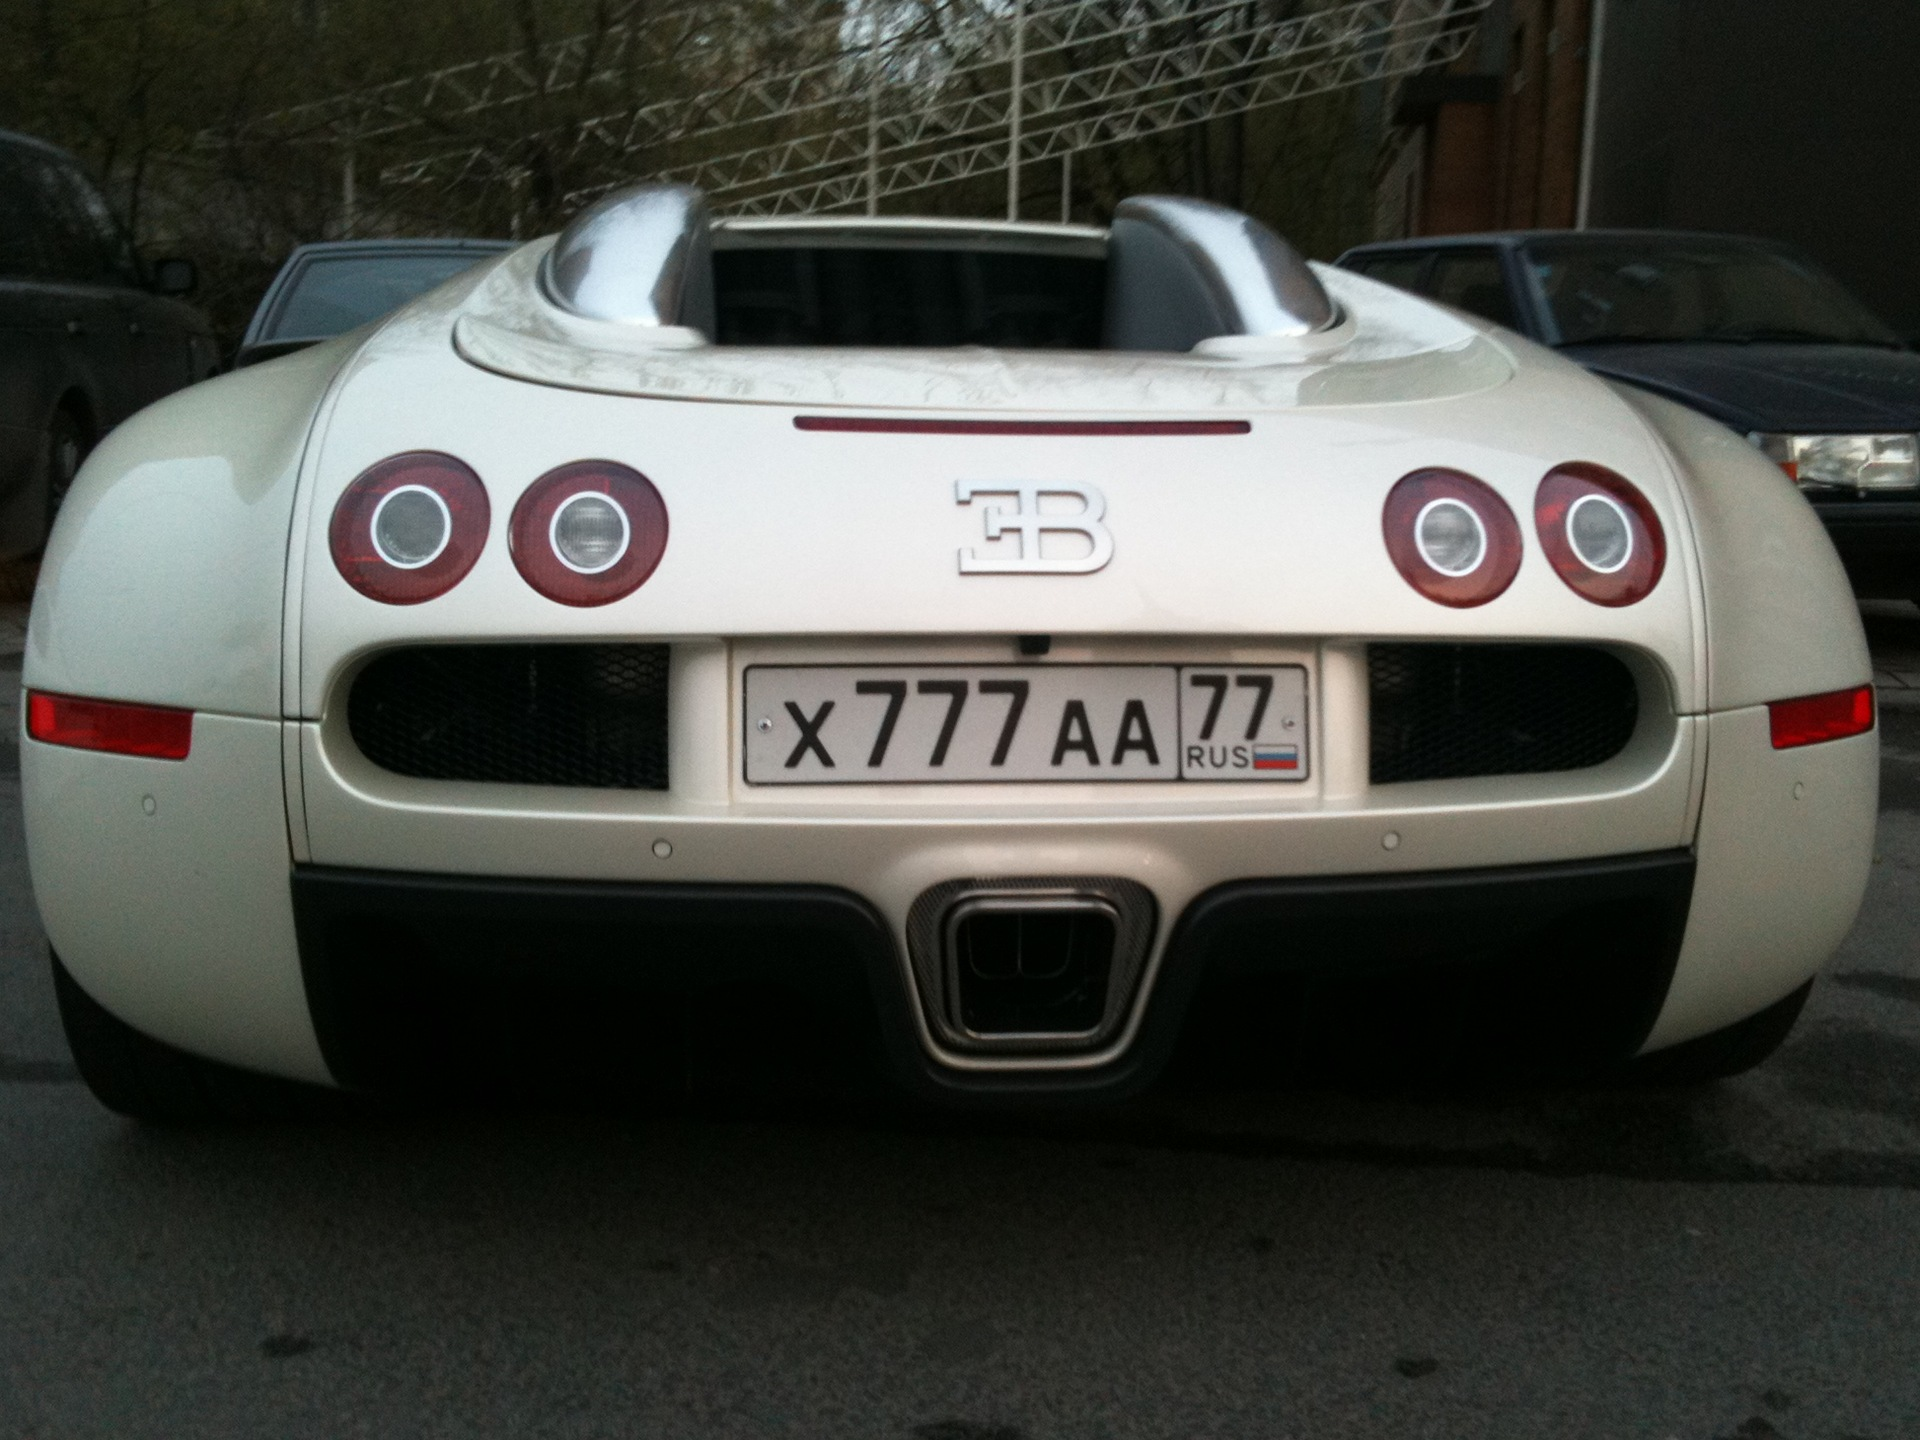

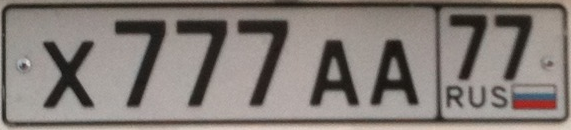

In [ ]:
img = cv2.imread('/content/sample_data/vehicleNum.jpg')
cv2_imshow(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # переводим в градации серого
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2) # устанавливаем порог для дальнейшего определения контура номерного знака
contours,h = cv2.findContours(thresh,1,2) # находим контуры
largest_rectangle = [0,0] 
for cnt in contours:
    approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
    if len(approx)==4: # В нашем примере мы делаем допущение, что номерной знак - четырехугольник.
        area = cv2.contourArea(cnt)
        if area > largest_rectangle[0]:
            largest_rectangle = [cv2.contourArea(cnt), cnt, approx]

x,y,w,h = cv2.boundingRect(largest_rectangle[1])
vehicle_num=img[y:y+h,x:x+w] # оставляем на исходном изображении только номер автомобиля
cv2_imshow(vehicle_num)

Разобъем номер на отдельные буквы/цифры, чтобы на вход модели подавать по одному символу. Заодно и определим размер изображения каждого символа, как 28х28 (это необходимо для дальнейшего использования в нашей модели).

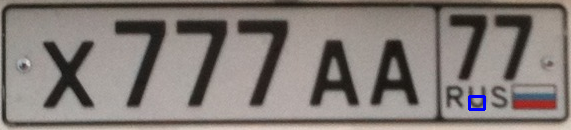

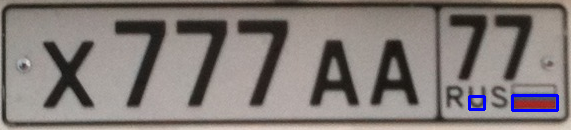

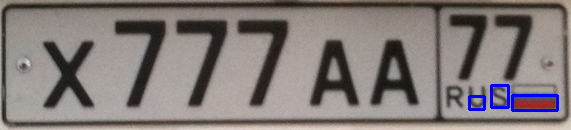

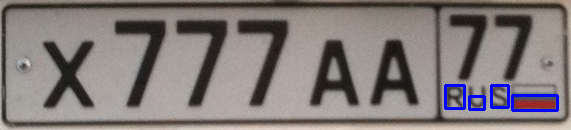

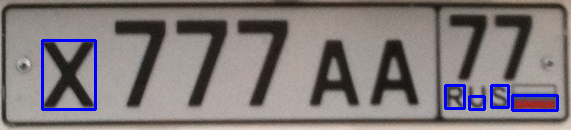

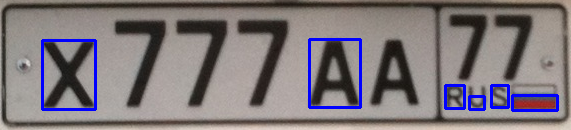

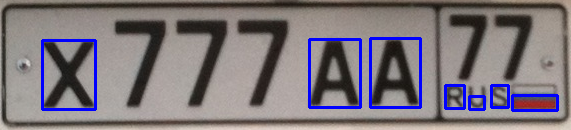

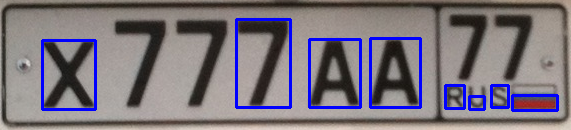

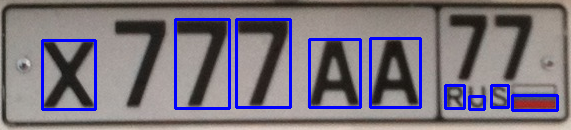

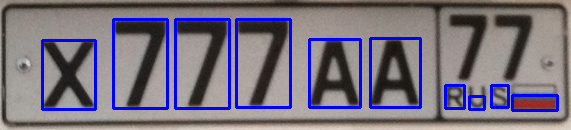

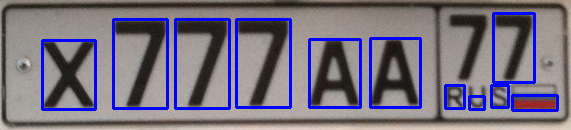

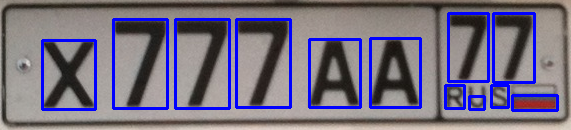

Выводим каждый символ отдельно, отсортировав по координате Х


In [ ]:
gray = cv2.cvtColor(vehicle_num, cv2.COLOR_BGR2GRAY) # уже работаем с выделенным участком изображения
ret, thresh = cv2.threshold(gray, 75, 255, cv2.THRESH_BINARY) 
img_erode = cv2.erode(thresh, np.ones((3, 3), np.uint8), iterations=1) # размываем границы объекта
contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) # находим контуры, используя иерархическую структуру
output = vehicle_num.copy()
letters = []
for idx, contour in enumerate(contours):
  (x, y, w, h) = cv2.boundingRect(contour)
  if w > 10 and h > 10:
    if hierarchy[0][idx][3] == 0:
      cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 2)
      letter_crop = gray[y:y + h, x:x + w]
      cv2_imshow(output)
      size_max = max(w, h) # выделяем область в виде квадрата
      letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
      if w > h:
        y_pos = size_max//2 - h//2
        letter_square[y_pos:y_pos + h, 0:w] = letter_crop
      elif w < h:
        x_pos = size_max//2 - w//2
        letter_square[0:h, x_pos:x_pos + w] = letter_crop
      else:
        letter_square = letter_crop
      out_size = 28  # устанавливаем размеры результирующего изображения для каждой буквы    
      letters.append((x, w, cv2.resize(letter_square, (out_size, out_size), interpolation=cv2.INTER_AREA))) 
letters.sort(key=lambda x: x[0], reverse=False) # сортируем относительно координаты Х
print("Выводим каждый символ отдельно, отсортировав по координате Х")
for i in range(0,len(letters)):
  cv2_imshow(letters[i][2])


Предобученную модель можно загрузить из файла:

In [ ]:
model = keras.models.load_model('/content/sample_data/emnist_symbols.h5')

Определим функцию предсказаний. Тут важно иметь в виду, что исходные данные для обучения и тренировки модели имеют размер 28х28 и перевернуты (для этого мы будем использовать np.fliplr и np.rot90).

In [ ]:
def emnist_predict_img(model, img):
    img_arr = np.expand_dims(img, axis=0)
    img_arr = 1 - img_arr/255.0
    img_arr[0] = np.rot90(img_arr[0], 3)
    img_arr[0] = np.fliplr(img_arr[0])
    img_arr = img_arr.reshape((1, 28, 28, 1))

    result = model.predict_classes([img_arr])
    return chr(emnist_labels[result[0]])

Поскольку у нас некая последовательность изображений, напишем соответсвующую функцию:

In [ ]:
def img_to_str(model, letters):
    result = ""
    for i in range(len(letters)):
        dn = letters[i+1][0] - letters[i][0] - letters[i][1] if i < len(letters) - 1 else 0
        cv2_imshow(letters[i][2])
        result += emnist_predict_img(model, letters[i][2])
        if (dn > letters[i][1]/4):
            result += ' '
    return result

In [ ]:
result = img_to_str(model, letters)
print(result)

X 777 AA R7W S7I


Ошибочно вывелась (определилась изначально на избражении) буква "U", последний сивол, который на самом деле является контуром флага, а также порядок "77 RUS", что объясняется тем, что символы мы отсортировали только по координате Х.


Данные пример ни в коем случае не показывает, как решать эту конкретную задачу, а демонстрирует возможности Feature Engineering. Мы рассмотрели не практический, а теоретический подход.